# Trabalho 5 - Transformada de Hough

Faça um documento jupyter notebook que forneça, com base na transformada de Hough modelada para círculos, a contagem e a descrição (coordenadas dos centros e raio) dos discos grandes presentes na imagem do exemplo (do trabalho 3 - segmentação dos discos claros usando a transformada top-hat). 

-------

Procedimento sugerido:

Use como base o resultado do trabalho 3. Inicialmente, subtraia o resultado do trabalho 3 da imagem original a fim de obter a segmentação dos discos. Em seguida, utilize um filtro para obter as bordas dos discos e binarize o resultado. Por fim, empregue a transformada de Hough para obter as informações desejadas.

-------

In [460]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from collections import defaultdict
from PIL import Image, ImageDraw

%matplotlib inline

# Funções

In [3]:
def img_threshold(img, threshold = 60):
    return threshold < img

In [4]:
def img2binary(img):
    """Binarization of image with threshold given"""
    img[img > 0] = 1
    return img

In [5]:
def sobel(img):
    sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(sobelx, -1)))
    gy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(sobely, -1)))
    
    return gx + gy

In [6]:
def plota(img, save = False, name = ''):
    num = len(img)
    fig = plt.figure(figsize = (15, 9))
    grid = plt.GridSpec(1, num, fig)
    
    for i in range(num):
        ax = fig.add_subplot(grid[0, i])
        ax.imshow(img[i], cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
    
    if save:
        plt.savefig(name)
        
    return fig

### Estratégia:

    1) Limiariza a entrada e a saída;
    2) Passar filtro mediano na entrada e na saída limiarizados;
    3) Fazer a diferença entra entrada e saída;
    4) Aplicar Sobel na diferença;

## Carregando as images

In [7]:
entrada = cv.imread('../images/cosmos_original.jpg', 0)
saida = cv.imread('../images/img_final.jpg', 0)

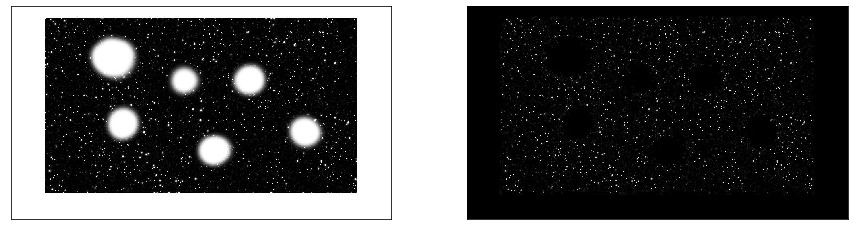

In [8]:
fig = plota([entrada, saida])

In [9]:
entrada_thres = img_threshold(entrada).astype(np.uint8)
saida_thres = img_threshold(saida).astype(np.uint8)

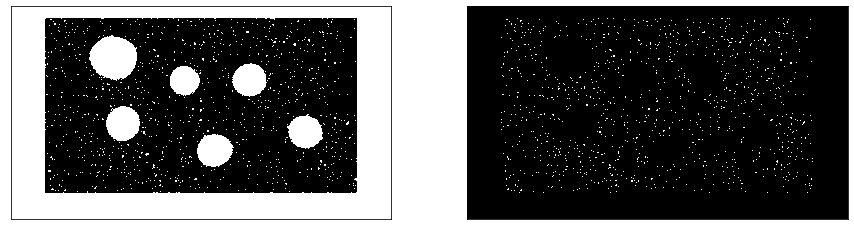

In [10]:
fig = plota([entrada_thres, saida_thres])

In [11]:
entrada_thres_med = cv.medianBlur(entrada_thres, 5)
saida_thres_med = cv.medianBlur(saida_thres, 5)

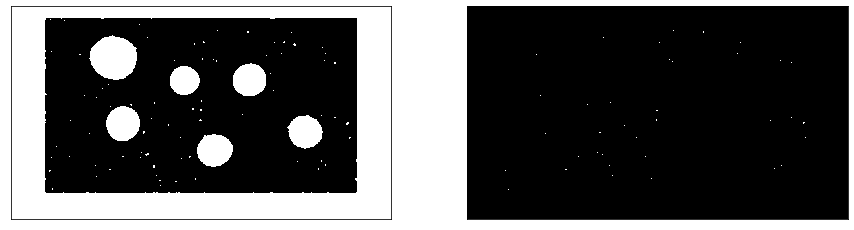

In [12]:
fig = plota([entrada_thres_med, saida_thres_med])

In [13]:
diff_thres_med = entrada_thres_med - saida_thres_med

In [14]:
diff_sob = sobel(diff_thres_med)

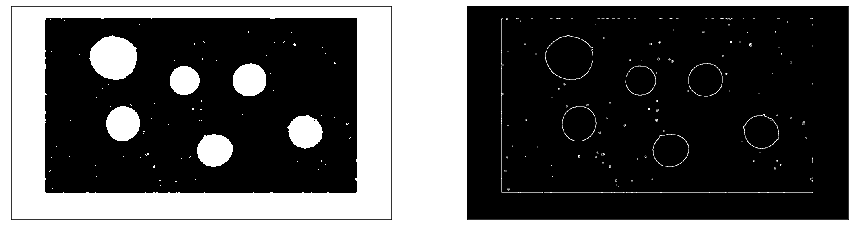

In [15]:
fig = plota([diff_thres_med, diff_sob])

In [16]:
diff_sob_bin = img2binary(np.copy(diff_sob))

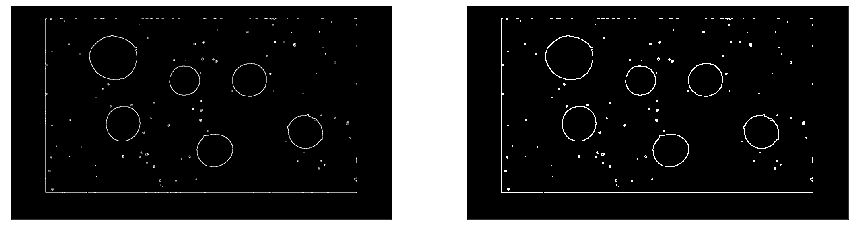

In [17]:
fig = plota([diff_sob, diff_sob_bin])

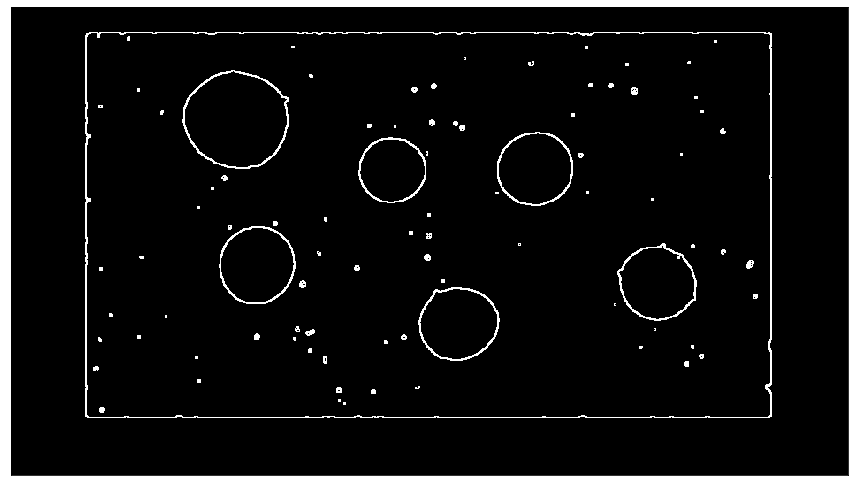

In [18]:
fig = plota([diff_sob_bin], save = True, name = '../images/diff_sob_bin.png')

In [158]:
gray = cv.bitwise_not(diff_sob_bin * 255)
bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                                cv.THRESH_BINARY, 3, -2)

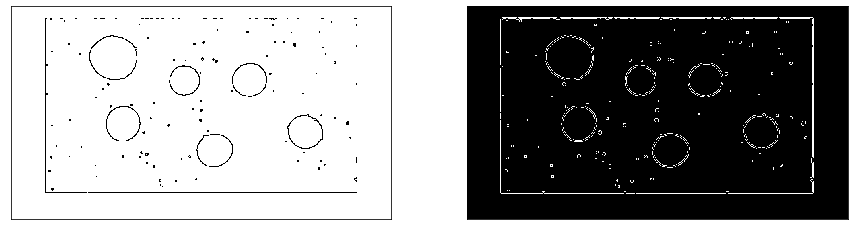

In [159]:
fig = plota([gray, bw])

In [370]:
def remove_straight_edges2(img, percent = 0.03):
    if img.max() != 255:
        horizontal = np.copy(img * 255)
        vertical = np.copy(img * 255)
    else:
        horizontal = np.copy(img)
        vertical = np.copy(img)
    
    kernel = np.ones((2, 2), np.uint8)
    
    n_rows, n_cols = img.shape
    horizontal_size = np.int(n_cols * percent)
    horizontal_structure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    horizontal = cv.erode(horizontal, horizontalStructure)
    horizontal = cv.dilate(horizontal, horizontalStructure)
    horizontal = cv.bitwise_not(horizontal)
    horizontal_edges = cv.adaptiveThreshold(horizontal, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                  cv.THRESH_BINARY, 3, -2)
    
    horizontal_edges = cv.dilate(horizontal_edges, kernel)
    horizontal_smooth = np.copy(horizontal)
    horizontal_smooth = cv.blur(horizontal_smooth, (3, 3))
    
    (rows, cols) = np.where(horizontal_edges != 0)
    horizontal[rows, cols] = horizontal_smooth[rows, cols]
    
    vertical_size = np.int(n_rows * percent)
    vertical_structure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))
    vertical = cv.erode(vertical, verticalStructure)
    vertical = cv.dilate(vertical, verticalStructure)
    vertical = cv.bitwise_not(vertical)
    vertical_edges = cv.adaptiveThreshold(vertical, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                  cv.THRESH_BINARY, 3, -2)
    
    vertical_edges = cv.dilate(vertical_edges, kernel)
    vertical_smooth = np.copy(vertical)
    vertical_smooth = cv.blur(vertical_smooth, (3, 3))
    
    (rows, cols) = np.where(vertical_edges != 0)
    vertical[rows, cols] = vertical_smooth[rows, cols]


    return cv.bitwise_not(vertical) + cv.bitwise_not(horizontal)

In [396]:
def remove_straight_edges(img, percent = 0.03):
    dimensions = img.shape
    horizontal_vertical = np.zeros(dimensions, np.uint8)
    kernel = np.ones((2, 2), np.uint8)
    
    for dim in range(len(dimensions)):
        print(dim)
        if img.max != 255:
            dimension = np.copy(img * 255)
        else:
            dimension = np.copy(img * 255)
        
        dim_size = np.int(dimensions[dim] * percent)
        
        if dim == 0:
            dim_structure = cv.getStructuringElement(cv.MORPH_RECT, (1, dim_size))
        elif dim == 1:
            dim_structure = cv.getStructuringElement(cv.MORPH_RECT, (dim_size, 1)) 
        else:
            print('Dimension not found!')
            break
        
        dimension = cv.erode(dimension, dim_structure)
        dimension = cv.dilate(dimension, dim_structure)
        dimension = cv.bitwise_not(dimension)
    
        dimension_edges = cv.adaptiveThreshold(dimension, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, -2)
        dimension_edges = cv.dilate(dimension_edges, kernel)
    
        dimension_smooth = np.copy(dimension)
        dimension_smooth = cv.blur(dimension_smooth, (3, 3))
        
        (rows, cols) = np.where(dimension_edges != 0)
        horizontal_vertical[rows, cols] = dimension_smooth[rows, cols]
    
    return horizontal_vertical
#     return cv.bitwise_not(vertical) + cv.bitwise_not(horizontal)

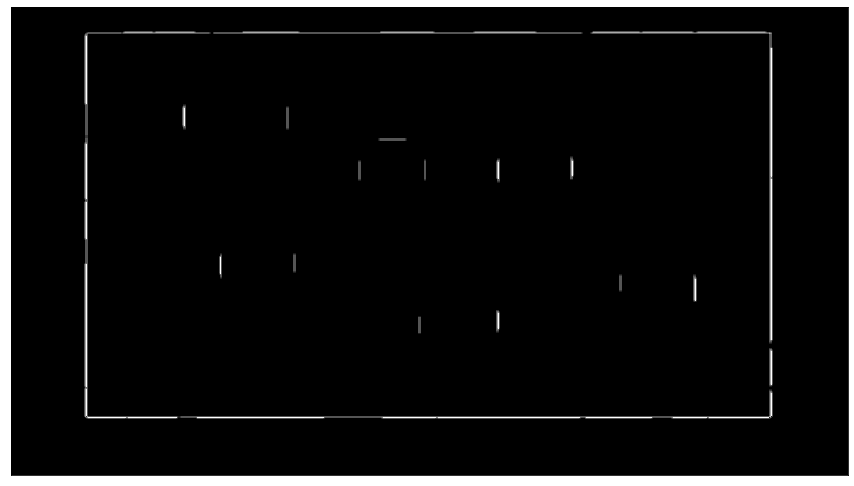

In [426]:
test = remove_straight_edges2(diff_sob_bin)
fig = plota([test])

In [427]:
test[np.where(test != 0)] = 255

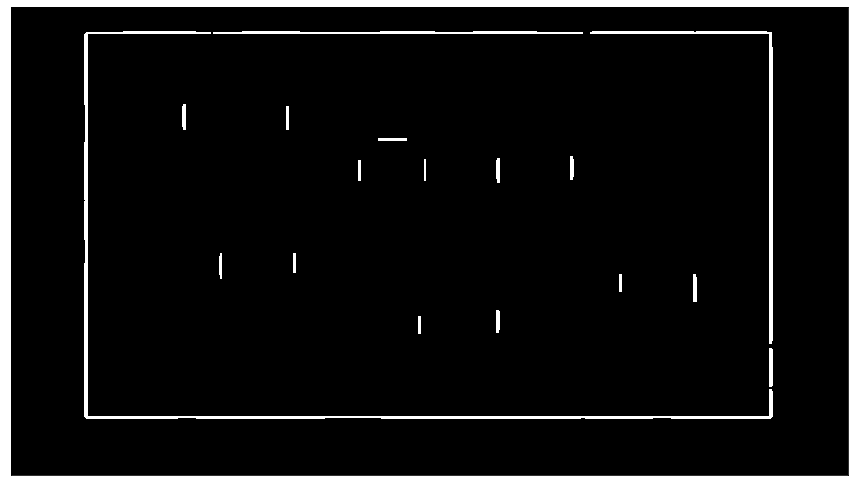

In [428]:
fig = plota([test])

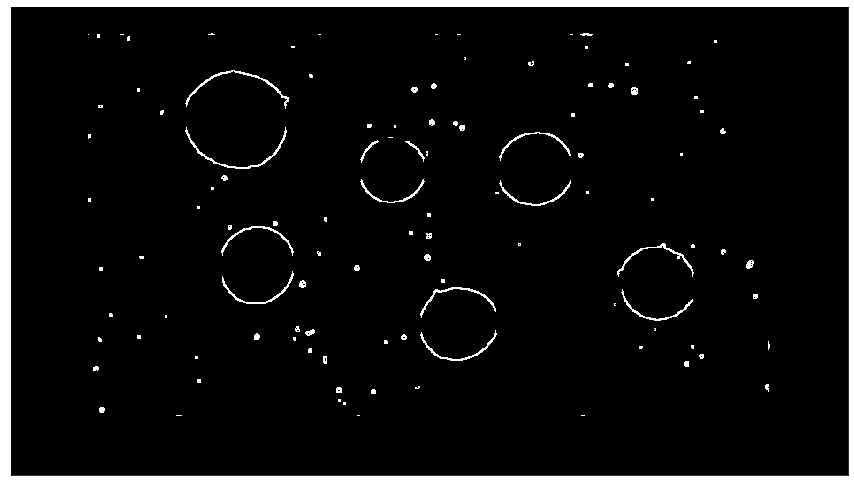

In [429]:
fig = plota([diff_sob_bin*255 - test])

In [430]:
img_test = diff_sob_bin*255 - test

In [431]:
img_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [432]:
n_rows, n_cols = img_test.shape

In [466]:
steps = 101
points = []

In [467]:
r_min = 25
r_max = 61
# r_max = np.ceil(0.5 * np.sqrt(n_cols**2 + n_rows**2)).astype(np.int)

In [468]:
for rr in range(r_min, r_max + 1):
    for t in range(steps):
        points.append((rr, int(rr * np.cos(2 * np.pi * t / steps)), int(rr * np.sin(2 * np.pi * t / steps))))

In [469]:
len(points)

3737

In [470]:
xyr = np.zeros([n_rows + 1, n_cols + 1, r_max + 1])
acc = defaultdict(int)

In [471]:
for cx in np.arange(n_rows):
    for cy in np.arange(n_cols):
        if img_test[cx, cy] > 0:    
            for r, x, y in points:
                if ((x + cx) > n_rows) or ((x + cx) < 0): continue
                if ((y + cy) > n_cols) or ((y + cy) < 0): continue
                xyr[x + cx, y + cy, r] += 1
                acc[(x + cx, y + cy, r)] += 1

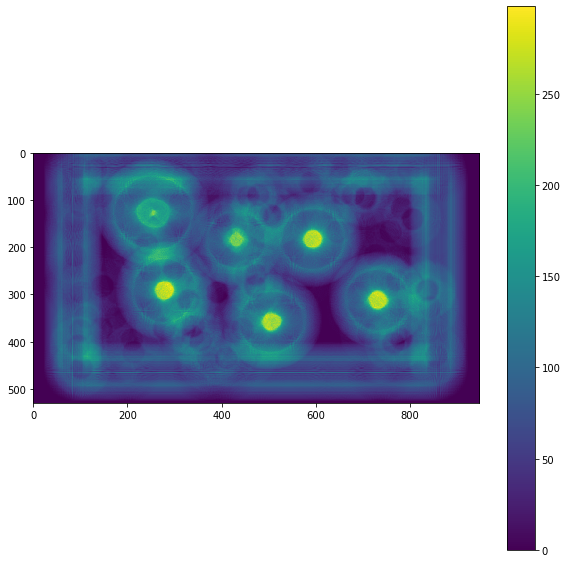

In [472]:
fig = plt.figure(figsize=(10,10))
plt.imshow(xyr.sum(axis=2))
plt.colorbar()

In [473]:
len(acc)

12249984

In [474]:
threshold = 0.3

In [481]:
circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
# for k, v in acc.items():
#     print(k, v)
    x, y, r = k
    if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        print(v / steps, x, y, r)
        circles.append((x, y, r))

0.7623762376237624 185 431 37
0.7524752475247525 184 593 42
0.7524752475247525 293 278 44
0.7128712871287128 313 731 42
0.594059405940594 359 504 42
0.5247524752475248 128 256 56


In [482]:
circles

[(185, 431, 37),
 (184, 593, 42),
 (293, 278, 44),
 (313, 731, 42),
 (359, 504, 42),
 (128, 256, 56)]

In [495]:
input_image = Image.fromarray(np.uint8(entrada))
diff_image = Image.fromarray(np.uint8(diff_sob_bin))

In [496]:
output_image = Image.new("RGB", input_image.size)
output_image_2 = Image.new("RGB", input_image.size)

output_image.paste(input_image)
output_image_2.paste(diff_image)

draw_result = ImageDraw.Draw(output_image)
draw_result_2 = ImageDraw.Draw(output_image_2)

In [497]:
for x, y, r in circles:
    draw_result.ellipse((y-r, x-r, y+r, x+r), outline=(255,0,0,0))
    draw_result_2.ellipse((y-r, x-r, y+r, x+r), outline=(255,0,0,0))

In [498]:
output_image.save("../images/entrada_test_1.png")
output_image_2.save("../images/diff_test_1.png")